# Linear Regression

We have to train a Linear Regression model on the `auto-mpg` dataset, which has features about a car from which we have to predict the mileage per gallon (mpg) fuel of the car.

## Data Preprocessing

We will import the necessary modules for the task at hand.

Following that, we will load the data as a pandas _DataFrame_, scale the features and make them ready for traning.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
file_path = "auto-mpg.csv"
df = pd.read_csv(file_path, header=0)

# to get number of NaN values in the dataframe
# df.isnull().sum().sum()

df.dropna(inplace=True) # drop all rows with NaN values in any column

df.drop(df[df['horsepower'] == "?"].index, inplace=True) # in this particular case, drops all rows with "?" in horsepower column.
df['horsepower'] = df['horsepower'].astype('float64')

For feature scaling we will use the Z-Score Normalization Technique which we will implement from scratch. The formula looks like:

$$ X_{(i)}^{normalized} = \frac{X_{(i)} - \mu_{(i)}}{\sigma_{(i)}}\ $$

$ X_{(i)} $ is the $ i^{th} $ feature.

$ \mu_{(i)} $ and $ \sigma_{(i)} $ are the mean and standard deviation of the $ i^{th} $ feature respectively.

In [ ]:
def feature_scaling(df):
  columns = df.columns
  for column in columns:
    n = len(df[column])
    mean = sum(df[column]) / n

    variance = 0
    for val in df[column]:
      variance += (val - mean) ** 2
    std = (variance / (n - 1)) ** 0.5

    df[column] = (df[column] - mean) / std
  return df

In [ ]:
scaled_features = feature_scaling(df.drop(columns=["car name", "mpg"], axis=1))

X = scaled_features.copy()
y = np.array(df['mpg'].copy()).reshape((X.shape[0], 1))

In [ ]:
m = X.shape[0] # number of training examples
n = X.shape[1] # number of features

print(f"Number of examples in the dataset = {m}")
print(f"Number of features = {n}")

Let's look at the first 5 examples of our dataset:

In [ ]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,1.482053,1.075915,0.663285,0.619748,-1.283618,-1.623241,-0.715726
1,1.482053,1.486832,1.572585,0.842258,-1.464852,-1.623241,-0.715726
2,1.482053,1.181033,1.182885,0.539692,-1.646086,-1.623241,-0.715726
3,1.482053,1.047246,1.182885,0.536160,-1.283618,-1.623241,-0.715726
4,1.482053,1.028134,0.923085,0.554997,-1.827320,-1.623241,-0.715726


## Linear Regression Model

In [ ]:
# Training Set    - 60%
# Validation Set  - 20%
# Test Set        - 20%

X_train, X_val_test, y_train, y_val_test = train_test_split(np.array(X), y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Linear Regression involves fitting a curve around some data points and getting the error (the difference between y coordinates of original data and the point projected onto that curve) to a minimum.

We have a quadratic function model which helps us predict values $\widehat{y}$ :
$$ \widehat{y} = f(\vec{x}) = w_{1}x_{1} + w_{2}x_{2} + ... + w_{n}x_{n} + w_{n+1}x^{2}_{1} + ... + w_{2n}x^{2}_{n} + b= \sum^{n}_{i=1} ( \, w_{i}x_{i} + w_{n+i}x^{2}_{i} \, ) \,\, + \, b$$

We need an error measurement equation, also known as the cost function which tracks the total error (MSE in this case) including the regularization error :
$$ J(X|w,b) = \frac{1}{2m} \left( \sum^{m}_{i=1} (f(\vec{x_{(i)}}) - y_{(i)})^{2} \, + \, \lambda \sum_{i=1}^{2n} w_{(i)}^{2} \right) $$

The above cost function will give the current total mean squared error of the model. The objective of our model is to $ \underset{w,b}{min} \,\, J(X|w,b) $. To do this mathematically we will use gradient descent.

$$ w := w - \alpha \frac{\partial J}{\partial w}$$
$$ b := b - \alpha \frac{\partial J}{\partial b} $$

First we calculate the gradients of J with respect to w and b respectively and then update both simultaneously. The gradients can be calculated by the below derived formulas:

$$ \frac{\partial }{\partial w_{j}} J(X|w,b) = \frac{1}{m} \left( \sum_{i=1}^{m} (f(\vec{x_{(i)}}) - y_{(i)})x_{(i, j)} \, + \, \lambda w_{j}\right) \, \forall \, j=1,...,n $$


$$ \frac{\partial }{\partial w_{j}} J(X|w,b) = \frac{1}{m} \left( 2\sum_{i=1}^{m} (f(\vec{x_{(i)}}) - y_{(i)})x^{2}_{(i, j)} \, + \, \lambda w_{j}\right) \, \forall \, j=(n+1),...,2n $$


$$ \frac{\partial }{\partial b} J(X|w,b) = \frac{1}{m} \left( \sum^m_{i=1} (f(\vec{x_{(i)}}) - y_{(i)})\right) $$

Using these steps we have to train our model, tune the weights `w` and bias `b` so as to fit the training data as well as possible and then we will we able to predict on new examples. After we train the model we will print the description of our Linear Regression model, and then plot the Cost vs Epochs graph to confirm that cost is decreasing as we go ahead on each iteration. Finally we will conclude by printing the training, validation and test set costs.

In [ ]:
class LinearRegression:
  def __init__(self, alpha=0.05, lambda_=1, epochs=200):
    self.epochs = epochs
    self.w = None
    self.b = None
    self.alpha = alpha
    self.lambda_ = lambda_
    self.cost_history = []

  def initialize_weights(self, n):
    self.w = np.random.rand(2*n, 1)
    self.b = np.random.rand(1)

  def model(self, X):
    n = X.shape[1]
    a = np.dot(X, self.w[:n,]) + np.dot(X**2, self.w[n:,]) + self.b
    return a

  def cost_function(self, X, y):
    squared_error = np.sum((self.model(X) - y) ** 2)
    regularization_term = (self.lambda_ * np.sum(self.w ** 2))
    cost = (squared_error + regularization_term) / (2 * X.shape[0])
    return cost

  def gradient_descent(self, X, y):
    m, n = X.shape
    fx = self.model(X)
    dJ_dw = np.zeros((2*n, 1))
    dJ_dw[:n,] = np.dot(X.T, fx - y) / m
    dJ_dw[n:,] = 2 * np.dot((X**2).T, fx - y) / m
    dJ_dw += (self.lambda_ / m) * self.w
    dJ_db = np.sum(fx - y) / m
    return dJ_dw, dJ_db

  def fit(self, X, y):
    self.initialize_weights(X.shape[1])
    for epoch in range(self.epochs):
      cost = self.cost_function(X, y)
      self.cost_history.append(cost)
      dJ_dw, dJ_db = self.gradient_descent(X, y)
      self.w = self.w - (self.alpha * dJ_dw)
      self.b = self.b - (self.alpha * dJ_db)

      #if epoch % (self.epochs // 5) == 0:
        #print(f"Epoch {epoch}/{self.epochs}")
        #print(f"{X.shape[0]}/{X.shape[0]} [===================================] - loss: {round(cost)}") """

  def plot(self):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(np.arange(1, self.epochs+1, 1), self.cost_history, linewidth=3)
    plt.title("Epochs vs Cost", fontdict={"fontsize": 17})
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.show()

  def predict(self, x):
    assert x.shape[1] == (self.w.shape[0] / 2), "Invalid Input Shape"
    return self.model(x)

  def about(self):
    print("LINEAR REGRESSION MODEL")
    print("______________________________________________")
    print("{:>20} = {:<7}".format("Number of Epochs", self.epochs))
    print("{:>20} = ({},{})".format("Shape of weights w", self.w.shape[0], self.w.shape[1]))
    print("{:>20} = {:<7}".format("Alpha", self.alpha))
    print("{:>20} = {:<7}".format("Lambda", self.lambda_))
    print("{:>20} = {:<7}".format("Final Cost", round(self.cost_history[-1], 3)))
    print("______________________________________________")

In [ ]:
# Iterative Grid Search

alphas = [1e-3, 3e-3, 5e-3, 1e-4, 3e-4, 5e-4]
lambdas = [1, 3, 5, 10, 20]
num_iterations = 3
epochs = 500

best_alpha, best_lambda, best_cost, LR = None, None, float('inf'), None
for iter in range(num_iterations):
  for alpha in alphas:
    for lambda_ in lambdas:
      lr = LinearRegression(alpha, lambda_, epochs)
      lr.fit(X_train, y_train)
      cost_val = lr.cost_function(X_val, y_val)
      if cost_val < best_cost:
        best_cost = cost_val
        best_alpha = alpha
        best_lambda = lambda_
        LR = lr
  alphas = [best_alpha * 0.25, best_alpha * 0.5, best_alpha, best_alpha * 1.5]
  lambdas = [best_lambda * 0.25, best_lambda * 0.5, best_lambda, best_lambda * 1.5]

In [ ]:
LR.about()

LINEAR REGRESSION MODEL
______________________________________________
    Number of Epochs = 500    
  Shape of weights w = (14,1)
               Alpha = 0.01125
              Lambda = 0.125  
          Final Cost = 7.694  
______________________________________________


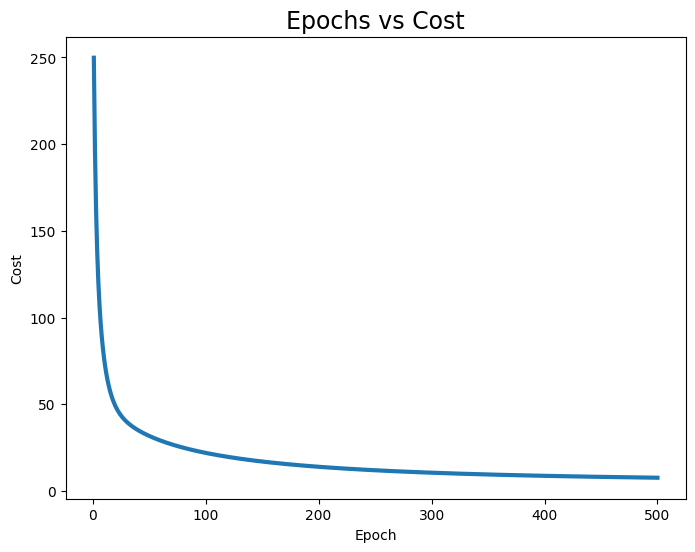

In [ ]:
LR.plot()

In [ ]:
training_cost = round(LR.cost_function(X_train, y_train), 3)
validation_cost = round(LR.cost_function(X_val, y_val), 3)
test_cost = round(LR.cost_function(X_test, y_test), 3)

print("{:>20} = {:<7}".format("Training Cost", training_cost))
print("{:>20} = {:<7}".format("Validation Cost", validation_cost))
print("{:>20} = {:<7}".format("Test Cost", test_cost))

       Training Cost = 7.685  
     Validation Cost = 9.266  
           Test Cost = 7.576  


**That's our Linear Regression model fully trained and ready to use!**

To run it on a new dataset, edit the _"Data Preprocessing"_ Section to load your new data and process it to remove all invalid values, convert everything to numerical data and then normalize the Data to make it ready for use in our model.

Then experiment with some values of `alphas` and `lambdas` in _"Linear Regression Model"_ Section to get accuracte results and graphs and your model on the new data is ready.